In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob
from scipy.signal import medfilt

import sys
sys.path.append("/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev")
from misc import *

In [2]:
"""
NOTE: 
the window size (ws) of 12 still does not get rid of trees blowing in the wind. 
There is still the problem concerning the cyclical noise in the activation array. 

trees blowing soln ides: 
 - filter
 - smooth
 - suck it up and deal with it later
 - later we could use peaks in the image to id points and maybe blobs
 --- we could then check to see if those blobs are wolves or not
 
cyclical noise soln idea: 
 - change window size to see if that affects activation arr
 - suck it up 
 - model the noise over time. Try to figure out what that signal is
 --- and then filter that noise out. Maybe get different frequencies 
 --- over time 

"""

'\nNOTE: \nthe window size (ws) of 12 still does not get rid of trees blowing in the wind. \nThere is still the problem concerning the cyclical noise in the activation array. \n\ntrees blowing soln ides: \n - filter\n - smooth\n - suck it up and deal with it later\n - later we could use peaks in the image to id points and maybe blobs\n --- we could then check to see if those blobs are wolves or not\n \ncyclical noise soln idea: \n - change window size to see if that affects activation arr\n - suck it up \n - model the noise over time. Try to figure out what that signal is\n --- and then filter that noise out. Maybe get different frequencies \n --- over time \n\n'

In [3]:
# the window size (ws) has been determined from experimental analysis
# the ws corresponds to the number of frames needed to create an effective
# std dev frame. Given a 12 frames, taking the std of these gives a useful 
# output that can be used for wolf detection
WINDOW_SIZE = 12

In [7]:
wolf_dir = "/Users/alex_wheelis/Documents/Fall2022/ECE 484/DCIM/100_BTCF"

wolf_vid_fs = glob(wolf_dir + "/*")


In [7]:

random_idx = np.random.randint(0,200)
test_vid_f = wolf_vid_fs[random_idx]

print(test_vid_f)

vid = load_video(test_vid_f, frames = 300)

vid = decrease_res_by_x(vid, int(vid.shape[2]/4), int(vid.shape[1]/4))
vid = vid.astype(np.int16)

In [9]:
count

3599

In [11]:
diff_activation = np.zeros(vid.shape[0], dtype = np.float16)
# difference frame implementation
diff_v = np.zeros(vid.shape, dtype = np.float16)

for i in range(1, vid.shape[0]):
    f1 = vid[i, ...].astype(np.float16)
    f0 = vid[i-1, ...].astype(np.float16)
    diff_f = f1-f0
    av_diff = np.absolute(diff_f)
    frame_activation = np.sum(av_diff/255)#(vid.shape[1]*vid.shape[2]*255)
#     if frame_activation < 800:
    diff_activation[i] = frame_activation
    diff_v[i] = av_diff

    
    

AttributeError: 'str' object has no attribute 'shape'

In [126]:
av_diff

array([[2., 0., 0., ..., 2., 1., 1.],
       [2., 0., 1., ..., 1., 6., 1.],
       [0., 2., 0., ..., 4., 1., 2.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float16)

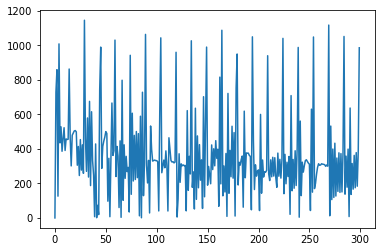

In [127]:
plt.plot(diff_activation)
plt.show()

In [10]:
time_col = diff_v[..., 135, 240]

NameError: name 'diff_v' is not defined

In [162]:
time_col.shape

(300,)

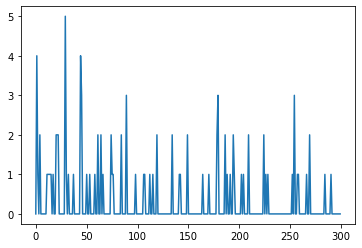

In [147]:
plt.plot(time_col)

In [182]:
t = np.linspace(0, 299)/60 #% Time vector
x = time_col #% Sample values vector

# % Create a couple of variables
Ts = t[1] - t[0]; #% Calculate the sampling period
fs = 1/Ts; #% Calculate the sampling frequency
fVec = np.linspace(0, fs, num=300) #% Create the frequency vector

In [11]:
# # % Calculate the frequency representation of the signal Vector
# X = np.fft.fft(x);

# # % Plot the magnitude spectrum (some alternatives)
# plt.plot(fVec, np.abs(X))#%; grid on;
# plt.xlabel("Frequency (Hz)")
# plt.ylabel("Amplitude (a.u.)")
# plt.title("2-Sided Magnitude - Linear Frequency Axis")

In [10]:
# # get rid of noise with high pass filter

# act_fft = np.fft.fft(diff_activation)
# act_fft_abs = np.abs(act_fft)

# act_min = np.min(act_fft_abs)
# act_max = np.max(act_fft_abs)

# highpass = act_fft.copy()
# lowpass = act_fft.copy()

# # these numbers are ARBITRARY please help!!!
# lowpass[act_fft_abs > act_min*1.5] = 0
# # .04 works
# highpass[act_fft_abs < act_max * .001] = 0


# new_act = np.fft.ifft(lowpass)

# new_act = linear_normalization(np.abs(new_act))

# plt.plot(new_act)
# plt.show()
# plt.plot(diff_activation)
# plt.show()

In [136]:
save_video_w_mvmt_annotations(vid, new_act, "is_wolf")

/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev/video/is_wolf.mp4


In [37]:
def create_std_vid(vid, f_name = None, window_size = WINDOW_SIZE):
#     pdb.set_trace()
    # window size
    ws = window_size
    # the last and first frame will be copied 

    # pad the video 
    padded_video = np.zeros(((vid.shape[0] - 4 + 2 * ws), vid.shape[1], vid.shape[2]),\
                            dtype = np.int16)

    # fill the padded video 
    padded_video[(ws-2) : vid.shape[0] + (ws-2), ...] = vid.copy()

    # copy last two frames
    padded_video[:(ws-2)] = vid[0].copy()
    padded_video[vid.shape[0] + (ws-2):, ...] = vid[-1].copy()

    # std dev video 
    std_v = np.zeros(vid.shape, dtype = np.int16)
    for i in range(0, std_v.shape[0]):
        std_frame = np.std(padded_video[i:i+ws], axis = 0)
        std_v[i] = std_frame.copy()



    #     diff_v[i] = np.abs(diff_f)
    #     diff_activation[i] = np.sum(diff_v[i])
    
    # normalize std_vid to 0-255 values
    std_v = std_v/np.max(std_v)
    std_v = std_v * 255 
    
    # anything less than 100 is 0
#     std_v[std_v < 100] = 0
    
    if f_name:
        save_video(std_v,f_name, fps = 60)
        
    return std_v

In [47]:
def get_activation_in_frames(vid_arr):
    # sum colors for each frame
#     pdb.set_trace()
    vid_arr = vid_arr/np.max(vid_arr)
    activation_arr = np.zeros(vid_arr.shape[0])
    
    sparsity_arr = np.zeros(vid_arr.shape[0])

    # memory constant
    mem_lambda = .3
    
    # moving average sum
    mv_sum = 0
    
    frame_area = (vid_arr.shape[1]*vid_arr.shape[2])
    
    for i, frame in enumerate(vid_arr):
        frame = vid_arr[i]
        # get activation in frame
        frame_activation = np.sum(frame)/frame_area
        # moving average ... doesn't work
        # mv_sum = frame_activation + mem_lambda * mv_sum
        
        # try to measure how sparse the pixels are 
        x_sum = np.sum(frame, 0)
        x_idx = np.arange(0, frame.shape[1])
        x_x = x_sum * x_idx
        x_std = np.std(x_x)
        
        y_sum = np.sum(frame, 1)
        y_idx = np.arange(0, frame.shape[0])
        y_y = y_sum * y_idx
        y_std = np.std(y_y)
        
        sparsity = (x_std + y_std)/2
        
        sparsity_arr[i] = sparsity
        activation_arr[i] = frame_activation
        
#         plt.imshow(frame)
#         plt.title(f"{x_std} {y_std}")
#         plt.show()
    
    activation_arr /= activation_arr.max()
    sparsity_arr /= sparsity_arr.max()

#     activation_arr = activation_arr/(vid_arr.shape[1]*vid_arr.shape[2])
    return activation_arr, sparsity_arr

In [33]:
if input("new video?\n") == "yes":
    random_idx = np.random.randint(0,200)
    test_vid_f = wolf_vid_fs[random_idx]

    print(test_vid_f)

    vid = load_video(test_vid_f, frames = 40*60)

    vid = decrease_res_by_x(vid, int(vid.shape[2]/4), int(vid.shape[1]/4))
    vid = vid.astype(np.int16)

new video?
 n


In [68]:
std_v = create_std_vid(vid, window_size = 12)
std_v[std_v < 10] = 0

In [57]:
std_v_copy = np.copy(std_v)

In [58]:
std_v_copy[std_v_copy < 10] = 0

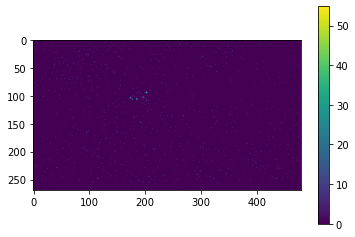

In [69]:
plt.imshow(std_v[8])
plt.colorbar()
plt.show()

In [70]:
activation_arr, sparsity_arr = get_activation_in_frames(std_v)

In [71]:
frame_idx = np.arange(0, activation_arr.shape[0])

save_video(vid, "raw")
act_arr = activation_arr/np.max(activation_arr)
save_video_w_mvmt_annotations(std_v, activation_arr, "std_w_activation", fps = 60)

/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev/video/raw.mp4
/Users/alex_wheelis/Documents/programming/red_wolf_detection/backend/algo_dev/video/std_w_activation.mp4


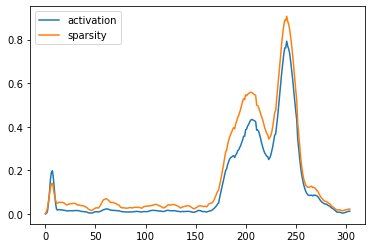

In [72]:
ran = range(0, 305)
plt.plot(frame_idx[ran], activation_arr[ran], label = "activation")
plt.plot(frame_idx[ran], sparsity_arr[ran], label = "sparsity")
plt.legend()
plt.show()

In [13]:
plt.plot(act_arr)
plt.show()


NameError: name 'act_arr' is not defined